## Review topic modeling 1
#### Granularity: one topic for all comments of a given listing.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

pd.set_option('display.max_columns', 100)

RANDOM_STATE= 42

In [2]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

In [3]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

In [4]:
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [5]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

import pyLDAvis.sklearn

### Prepare reviews

In [7]:
# load cleaned review dataset
review_df = pd.read_pickle('../data/data_cleaned/cleaned_review.zip')
print(review_df.shape)

# group comments by listing_id
grouped_review = review_df.groupby('listing_id').agg(lambda x: ' '.join(x)).reset_index()
print(grouped_review.shape)

(375173, 4)
(5091, 2)


In [8]:
# # use a small sample data to run
# sample_review = grouped_review.sample(200, random_state = RANDOM_STATE).reset_index(drop=True)
# sample_review.head(2)

In [9]:
# use all data to run
sample_review = grouped_review.copy()
sample_review.head(2)

,listing_id,comments
0,6606,"The Urban Cottage is comfortable, beautiful, f..."
1,9419,"If you love art, animals, and yoga, this is th..."


### Preprocess reviews

In [10]:
def preprocess_text(text, stopwords = None, stem=False, lemma=False):
    # clean the text
    text = text.lower()
    # remove html and all other sybols 
    text = re.sub("(<.*?>)|([^0-9A-Za-z \t])"," ",text)
    
    # tokenize the text
    text = word_tokenize(text)     
    # remove stopwords and non alpha words
    text = [word for word in text if word not in stopwords]
    
    # get the root of word
    if stem == True:   
        stemmer = PorterStemmer()
        text = [stemmer.stem(word) for word in text]   
    
    # normalize the word  
    if lemma == True:
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text]
        
    # list to string
    text = ' '.join(text)  
    
    return text

In [11]:
# create a function to pull out specific part of speech from a string of text
def get_adjs(text):
    '''Given a string of text, tokenize the text and pull out only the adjectives.'''
    text_list = text.split()
    is_adjs = lambda pos: pos[:2] == 'JJ'
    all_adjs = [word for (word, pos) in pos_tag(text_list) if is_adjs(pos)] 
    return ' '.join(all_adjs)

def get_nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    text_list = text.split()
    is_noun = lambda pos: pos[:2] == 'NN'
    all_nouns = [word for (word, pos) in pos_tag(text_list) if is_noun(pos)] 
    return ' '.join(all_nouns)

def get_nouns_adjs(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    text_list = text.split()
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    nouns_adj = [word for (word, pos) in pos_tag(text_list) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [12]:
# prepare stopword set
added_stopwords = ["can't",'t', 'us', 'say','would', 'also','within','stay', 'since']
nltk_STOPWORDS = set(stopwords.words("english"))
nltk_STOPWORDS.update(added_stopwords)

In [13]:
%%time
# get cleaned comments
sample_review['cleaned_comments'] = sample_review['comments'] \
                                    .apply(lambda x: preprocess_text(
                                            x,stopwords = nltk_STOPWORDS, 
                                            stem=False, lemma=True))

CPU times: user 1min 24s, sys: 350 ms, total: 1min 25s
Wall time: 1min 25s


In [14]:
%%time

# only keep nouns and adjs from the cleaned_comments tokens
sample_review['comments_nouns_adjs'] = sample_review['cleaned_comments'].apply(get_nouns_adjs)
# sample_review['comments_nouns'] = sample_review['cleaned_comments'].apply(get_nouns)
# sample_review['comments_adjs'] = sample_review['cleaned_comments'].apply(get_adjs)

CPU times: user 6min 51s, sys: 664 ms, total: 6min 51s
Wall time: 6min 52s


In [15]:
sample_review.head(3)

,listing_id,comments,cleaned_comments,comments_nouns_adjs
0,6606,"The Urban Cottage is comfortable, beautiful, f...",urban cottage comfortable beautiful fun really...,urban cottage comfortable beautiful fun conven...
1,9419,"If you love art, animals, and yoga, this is th...",love art animal yoga place niece visiting port...,art animal yoga place portland springfield mo ...
2,9531,"My husband, 2 year old daughter and I stayed a...",husband 2 year old daughter stayed sweet orang...,husband year old daughter sweet orange several...


### Identify top n words

In [16]:
def get_top_n_words(text, top_n = 5):
    top_n_words = Counter(text.split()).most_common(top_n)
    # get only the words exclude the word count
    top_n_words = [word for word, count in top_n_words]
    
    return top_n_words

In [17]:
# d = sample_review['cleaned_comments'].apply(lambda text: get_top_n_words(text, top_n=5))
# print(d)

### Generate review wordcloud

In [18]:
def make_wordcloud(df, col, listing_id, stop_words, mask=None):
    
    if listing_id in df['listing_id'].values:
        text = df[df['listing_id'] == listing_id][col].values[0]
        wordcloud = WordCloud(width = 1000, 
                              height = 1000, 
                              stopwords=stop_words, 
                              scale=10, 
                              colormap = 'PuRd', 
                              background_color ='white',
#                               mask = None,
                              max_words=100,
                             ).generate(text)

        plt.figure(figsize=(8,8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        print('Oops, this listing currently has no comments.') 

In [19]:
# generate wordcloud for a given listing (has comments)
# wordcloud_STOPWORDS = STOPWORDS
# make_wordcloud(sample_review,'comments_nouns_adjs', 2693700, wordcloud_STOPWORDS, mask=None)

### LDA topic modeling - on nouns and adjectives

We found topics from the nouns and adjectives for each review made the most sense after attempting topic modeling on all review tokens, only on noun tokens, and only on adj tokens in each review.

In [35]:
# prepare clean corpus

review_corpus = sample_review['comments_nouns_adjs'].values.tolist()
# removed reviews without tokens to avoid error in pyLDAvis
review_corpus = [doc for doc in review_corpus if len(doc)>5]
print(len(review_corpus))
# review_corpus

5087


In [36]:
# create document-term matrix 

# CountVectorizer
tf_vectorizer = CountVectorizer(
                                ngram_range = (1,2), 
                                min_df=2, 
                                max_df=0.9,
                                stop_words='english')

tf_documents = tf_vectorizer.fit_transform(review_corpus)

# get feature name and vocabulary
tf_feature_names = tf_vectorizer.get_feature_names()
tf_vocab = tf_vectorizer.vocabulary_

print(tf_documents.shape)
print("Number of unique terms in vocabulary:", len(tf_feature_names))
# print("doc-term matrix initial row (first document vector):\n", tf_documents[0:1] )

(5087, 363954)
Number of unique terms in vocabulary: 363954


In [37]:
%%time
# create topic using LDA

n_topics = 6

lda = LatentDirichletAllocation(n_components = n_topics, random_state=RANDOM_STATE)
lda.fit(tf_documents)
lda_topic_components = lda.components_

CPU times: user 4min 49s, sys: 45.4 s, total: 5min 34s
Wall time: 1min 36s


In [38]:
# display top n words in each topic

num_top_words = 10

def display_topics(model, feature_names, no_top_words):
    
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list)


display_topics(lda, tf_feature_names, num_top_words)

topic 0: ['loft', 'tri', 'james', 'hal', 'room', 'alice', 'hotel', 'unique', 'angielena', 'cool']
topic 1: ['seattle', 'clean', 'host', 'comfortable', 'space', 'nice', 'neighborhood', 'quiet', 'easy', 'perfect']
topic 2: ['apartment', 'clean', 'seattle', 'great location', 'space', 'host', 'easy', 'perfect', 'restaurant', 'comfortable']
topic 3: ['clean', 'seattle', 'host', 'comfortable', 'home', 'house', 'nice', 'space', 'easy', 'view']
topic 4: ['clean', 'room', 'nice', 'good', 'easy', 'comfortable', 'host', 'great location', 'apartment', 'night']
topic 5: ['house', 'seattle', 'home', 'host', 'comfortable', 'clean', 'beach', 'time', 'room', 'beautiful']


In [39]:
# get document weights per topic

def get_best_document_per_topic(review_corpus, model, document_matrix):

    output = model.transform(document_matrix)
    # print("NMF transform output:\n", nmf_output)
    best_document_per_topic = np.argsort(output, axis = 0)[::-1]
    for topic_index in range(0, n_topics):
        best_index = best_document_per_topic[0, topic_index]
        print("Highest topic", topic_index, "weight is document", 
              best_index, ":", review_corpus[best_index][0:30])
        
get_best_document_per_topic(review_corpus,lda,tf_documents)

Highest topic 0 weight is document 2934 : super unique history bit rough
Highest topic 1 weight is document 277 : great host son showed separate
Highest topic 2 weight is document 541 : great location easy distance c
Highest topic 3 weight is document 76 : becky house beautiful great ne
Highest topic 4 weight is document 187 : honest sake people interested 
Highest topic 5 weight is document 384 : great place porch peaceful fre


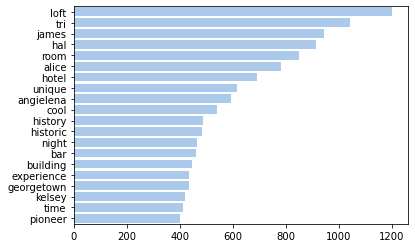

In [40]:
# display a bar chart of top_n topic weights

def top_n_topic_weights(topic_components,feature_names, topic_index):

    vocab = np.array(feature_names)
    top_term_indices = np.array(np.argsort(topic_components[topic_index, :])[::-1])[0:20]

    term_strings = vocab[top_term_indices]
    term_weights = topic_components[topic_index, top_term_indices]

    sns.set_color_codes("pastel")
    sns.barplot(x=term_weights, y=term_strings, label="Weight", color="b")

    plt.show()

# show the topic weight for topic 1
topic_index = 0
top_n_topic_weights(lda_topic_components, tf_feature_names, topic_index)

In [41]:
# visualize topics and words
def visualize_topics(model, document_matrix, vectorizer, mds='tsne'):
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(model, document_matrix, vectorizer, mds='tsne')
    display(panel)
    
visualize_topics(lda, tf_documents, tf_vectorizer)

/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Users/abbyz/opt/anaconda3

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3       1.465019 -47.625065       1        1  42.052899
1      54.854797 -36.476795       2        1  29.156868
2      32.212929 -61.444572       3        1  19.389308
4       5.111096 -14.110332       4        1   5.142230
5      26.350170 -33.374702       5        1   3.236527
0      38.109818  -7.222781       6        1   1.022168, topic_info=             Term           Freq          Total Category  logprob  loglift
271344       room   39667.000000   39667.000000  Default  30.0000  30.0000
158035      house   52948.000000   52948.000000  Default  29.0000  29.0000
150668       home   57429.000000   57429.000000  Default  28.0000  28.0000
58517       clean  110155.000000  110155.000000  Default  27.0000  27.0000
277260    seattle   99196.000000   99196.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
128201        fun     216.218536    8216.513494   Topic6  -6.2060   0.9456
322617       time     260.199698   44932.188456   Topic6  -6.0208  -0.5682
189740        lot     208.333941   28908.958956   Topic6  -6.2431  -0.3495
30511   beautiful     180.216373   38144.365614   Topic6  -6.3881  -0.7717
277260    seattle     176.686102   99196.783955   Topic6  -6.4079  -1.7472

[528 rows x 6 columns], token_table=        Topic      Freq         Term
term                                
60          1  0.021054        aaron
60          4  0.973735        aaron
74          4  0.982535  aaron place
9113        5  0.984508     alasdair
9171        1  0.049638         alex
...       ...       ...          ...
363542      5  0.992765         yumi
363623      1  0.004149       yvonne
363623      2  0.095431       yvonne
363623      5  0.900366       yvonne
363709      4  0.997207         zeus

[1200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 6, 1])

In [42]:
# get topic label per document

# lda.transform(tf_documents).argmax(axis=1)

## add topic label to the review dataframe
# sample_review['topic'] = lda.transform(tf_documents).argmax(axis=1)

### NMF for topic modeling

In [43]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
                                ngram_range = (1,2), 
                                min_df=2,  
                                max_df=0.9, 
                                stop_words='english') 

tfidf_documents = tfidf_vectorizer.fit_transform(review_corpus)


# get feature name and vocabulary
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_documents.shape)
print("Number of unique terms in vocabulary:", len(tfidf_feature_names))
# print("doc-term matrix initial row (first document vector):\n", tfidf_documents[0:1] )

(5087, 363954)
Number of unique terms in vocabulary: 363954


In [44]:
# create topic using NMF

nmf = NMF(n_components=n_topics, random_state=RANDOM_STATE)
nmf.fit(tfidf_documents )
nmf_topic_components = nmf.components_

/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

In [45]:
# display top n words in each topic

display_topics(nmf, tfidf_feature_names, num_top_words)

topic 0: ['apartment', 'great location', 'seattle', 'clean', 'restaurant', 'space', 'easy', 'perfect', 'distance', 'host']
topic 1: ['house', 'home', 'family', 'beautiful', 'comfortable', 'group', 'host', 'seattle', 'neighborhood', 'clean']
topic 2: ['view', 'beautiful', 'great view', 'rooftop', 'deck', 'beautiful view', 'view great', 'seattle', 'location view', 'balcony']
topic 3: ['cottage', 'beach', 'west seattle', 'seattle', 'west', 'alki', 'comfortable', 'cozy', 'host', 'perfect']
topic 4: ['clean', 'room', 'host', 'nice', 'comfortable', 'easy', 'seattle', 'space', 'quiet', 'good']
topic 5: ['melissa', 'apartment', 'uw', 'university', 'good', 'campus', 'melissa place', 'melissa great', 'district', 'unit']


In [46]:
# get document weights per topic
get_best_document_per_topic(review_corpus,nmf,tfidf_documents)

Highest topic 0 weight is document 44 : serina apartment wonderful loc
Highest topic 1 weight is document 1002 : gorgeous house perfect housing
Highest topic 2 weight is document 1274 : easy day many seattle attracti
Highest topic 3 weight is document 190 : great place host wonderful eve
Highest topic 4 weight is document 974 : great place awesome helpful in
Highest topic 5 weight is document 133 : great location uw melissa prom


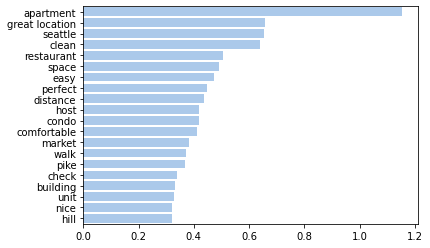

In [47]:
# display topic weights
top_n_topic_weights(nmf_topic_components, tf_feature_names, 0)

In [48]:
# get topic label per document

# nmf.transform(tfidf_documents).argmax(axis=1)

## add topic label to the review dataframe
# sample_review['topic'] = lda.transform(tf_documents).argmax(axis=1)

In [49]:
visualize_topics(nmf, tfidf_documents, tfidf_vectorizer)

/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Users/abbyz/opt/anaconda3

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4       1.465019 -47.625065       1        1  27.229537
1      54.854797 -36.476795       2        1  23.066165
0      32.212929 -61.444572       3        1  21.305214
3       5.111096 -14.110332       4        1  13.118057
2      26.350170 -33.374702       5        1   9.584343
5      38.109818  -7.222781       6        1   5.696686, topic_info=             Term        Freq       Total Category  logprob  loglift
345155       view  174.000000  174.000000  Default  30.0000  30.0000
158035      house  204.000000  204.000000  Default  29.0000  29.0000
199846    melissa   82.000000   82.000000  Default  28.0000  28.0000
13499   apartment  157.000000  157.000000  Default  27.0000  27.0000
77840     cottage   89.000000   89.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
84947         day    5.393823   75.885894   Topic6  -6.8716   0.2213
322617       time    5.469279  121.512315   Topic6  -6.8577  -0.2356
189740        lot    5.129658   86.900097   Topic6  -6.9218   0.0356
154255       host    5.155626  224.858798   Topic6  -6.9168  -0.9101
305558     street    4.889439   73.886175   Topic6  -6.9698   0.1498

[650 rows x 6 columns], token_table=        Topic      Freq            Term
term                                   
433         2  1.071863      able house
1782        3  1.507284     access pool
5287        3  1.047247          adrian
5320        2  0.748590           adult
5320        3  0.172752           adult
...       ...       ...             ...
359339      3  0.174850       wonderful
359339      4  0.203991       wonderful
359339      5  0.106853       wonderful
360434      5  0.980388  wonderful view
363542      4  1.198775            yumi

[796 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3, 6])

Findings:

1. Topic modeling on nouns and adjectives make more sense than on all the text reviews.
2. NMF works better than IDA. NMF takes shorter time to train, and the top_n terms make more sense to interpret.

### Interpret topics 

After trying different number of topics on the nouns and adjectives of the reviews, we found 6 topics made the most sense. Below are the topics we interpreted.

From the top 30 terms in each topic, we found that:

- Topic 1: review about listing (room) cleanness
- Topic 2: review about listing (house) family friendliness
- Topic 3: review about listing (apartment) location
- Topic 4: review about listing (cottage) beach
- Topic 5: review about listing (Seattle downtown) views
- Topic 6: review about listing (university-district) hosts

#### Generate wordcloud for a given listing 

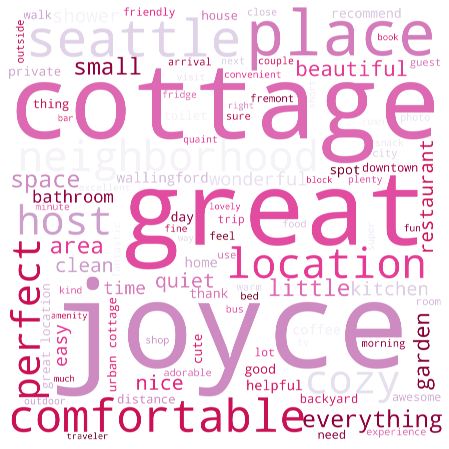

In [51]:
# generate wordcloud for the first listing as an example
wordcloud_STOPWORDS = STOPWORDS
listing_id = sample_review['listing_id'].values[0]
make_wordcloud(sample_review,'comments_nouns_adjs', listing_id, wordcloud_STOPWORDS, mask=None)

In [54]:
# # save the dataset that contains the preprocessed nouns and adjectives 
# # of all the listing comments for future wordcloud plots.

# sample_review.to_pickle('../data/data_cleaned/cleaned_review_for_wordcloud.zip')

In [55]:
# # check the saved dataset
# df = pd.read_pickle('../data/data_cleaned/cleaned_review_for_wordcloud.zip')
# print(df.shape)
# df.head(2)

(5091, 4)


,listing_id,comments,cleaned_comments,comments_nouns_adjs
0,6606,"The Urban Cottage is comfortable, beautiful, f...",urban cottage comfortable beautiful fun really...,urban cottage comfortable beautiful fun conven...
1,9419,"If you love art, animals, and yoga, this is th...",love art animal yoga place niece visiting port...,art animal yoga place portland springfield mo ...


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a50dc6-ff6a-45ff-9dbe-d7a35bd1e393' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>